In [1]:
from music21 import *
import pandas as pd
import numpy as np
import pickle
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import os
if not os.path.exists('../figures'):
    os.mkdir('../figures')

### Feature Extraction
Features extracted:
- MIDI pitches
- Rhythms
- Chords (roman numerals)

In [2]:
# Extract features from the corpus and place each piece in the chorales_train variable
# --------------------------------------------------------------------------------
bachCorpus = corpus.getComposer('bach')
chorales_notes_train = [] #all chorale note tuples stored as a list
chorales_chords_train = [] #all chorale chord sequences stored as a list

# Keep track of all features encountered
all_durations = []
all_notes = []
all_chords = []

for piece in bachCorpus:    
    pieceScore = corpus.parse(piece)  # stream.Score object
    melodyPart = pieceScore.getElementsByClass('Part')[0]  # melody parts are always the first part in the score
    melodyNotes = melodyPart.flat.getElementsByClass('Note') #extract all notes in the part
    
    print('Processing chorale: {}'.format(pieceScore.metadata.title))

    
    #Chordify and extract chord sequences
    # ---------------------------------->
    bChords = pieceScore.chordify()
    #Condense all chords into the middle range of treble clef 
    for c in bChords.recurse().getElementsByClass('Chord'):
        c.closedPosition(forceOctave=4, inPlace=True)
        
    #Analyze roman numerals
    bKey = None
    for keychange in melodyPart.recurse().getElementsByClass(key.Key):
        #Get key of piece (for chord context)
        bKey = keychange
    for c in bChords.recurse().getElementsByClass('Chord'):
        rn = roman.romanNumeralFromChord(c, bKey)
        c.addLyric(str(rn.figure))
    
    #Collect chord sequence in a list
    chordSequence = []
    for c in bChords.flat:
        if 'Chord' not in c.classes:
            continue
        chordSequence.append(c.lyric)
        all_chords.append(c.lyric) #keep a running total of all chords seen
    
    chorales_chords_train.append(chordSequence) #store this piece's chord sequence in master list
    
    
    #Extract note pitches and rhythms
    # --------------------------------
    noteSequence = [] #series of all notes in order, from start to end of piece
    for n in melodyNotes.recurse():  # iterates through all notes in the piece
        midiNote = n.pitch.midi
        noteDuration = n.duration.quarterLength
        noteTuple = (midiNote, noteDuration) # (MIDI_pitch, note_duration)
        
        # Keep track of all notes and durations seen thus far
        all_durations.append(noteDuration) 
        all_notes.append(midiNote)
            
        noteSequence.append(noteTuple) # appends the next time step to the sample
        
    chorales_notes_train.append(noteSequence) #store this piece's sequence of notes in master list

Processing chorale: bwv1.6.mxl
Processing chorale: bwv10.7.mxl
Processing chorale: bwv101.7.mxl
Processing chorale: bwv102.7.mxl
Processing chorale: bwv103.6.mxl
Processing chorale: bwv104.6.mxl
Processing chorale: bwv108.6.mxl
Processing chorale: bwv11.6.mxl
Processing chorale: bwv110.7.mxl
Processing chorale: bwv111.6.mxl
Processing chorale: bwv112.5-sc.mxl
Processing chorale: bwv112.5.mxl
Processing chorale: bwv113.8.mxl
Processing chorale: bwv114.7.mxl
Processing chorale: bwv115.6.mxl
Processing chorale: bwv116.6.mxl
Processing chorale: bwv117.4.mxl
Processing chorale: bwv119.9.mxl
Processing chorale: bwv12.7.mxl
Processing chorale: bwv120.6.mxl
Processing chorale: bwv120.8-a.mxl
Processing chorale: bwv121.6.mxl
Processing chorale: bwv122.6.mxl
Processing chorale: bwv123.6.mxl
Processing chorale: bwv124.6.mxl
Processing chorale: bwv125.6.mxl
Processing chorale: bwv126.6.mxl
Processing chorale: bwv127.5.mxl
Processing chorale: bwv128.5.mxl
Processing chorale: bwv13.6.mxl
Processing 

Processing chorale: bwv346.mxl
Processing chorale: bwv347.mxl
Processing chorale: bwv348.mxl
Processing chorale: bwv349.mxl
Processing chorale: bwv350.mxl
Processing chorale: bwv351.mxl
Processing chorale: bwv352.mxl
Processing chorale: bwv353.mxl
Processing chorale: bwv354.mxl
Processing chorale: bwv355.mxl
Processing chorale: bwv356.mxl
Processing chorale: bwv357.mxl
Processing chorale: bwv358.mxl
Processing chorale: bwv359.mxl
Processing chorale: bwv36.4-2.mxl
Processing chorale: bwv36.8-2.mxl
Processing chorale: bwv360.mxl
Processing chorale: bwv361.mxl
Processing chorale: bwv362.mxl
Processing chorale: bwv363.mxl
Processing chorale: bwv364.mxl
Processing chorale: bwv365.mxl
Processing chorale: 113. Ihr Gestirn', ihr hohen L\u3fte
Processing chorale: bwv366.mxl
Processing chorale: bwv367.mxl
Processing chorale: bwv368.mxl
Processing chorale: bwv369.mxl
Processing chorale: bwv37.6.mxl
Processing chorale: bwv370.mxl
Processing chorale: bwv371.mxl
Processing chorale: bwv372.mxl
Proces

In [3]:
#View durations frequencies of all chorales
durations_dict = Counter(all_durations)
durations_dict

Counter({1.0: 13675,
         0.5: 4822,
         0.25: 1471,
         2.0: 1921,
         1.5: 308,
         4.0: 96,
         3.0: 427,
         0.75: 47,
         8.0: 1,
         6.0: 5,
         0.125: 64,
         0.0: 2})

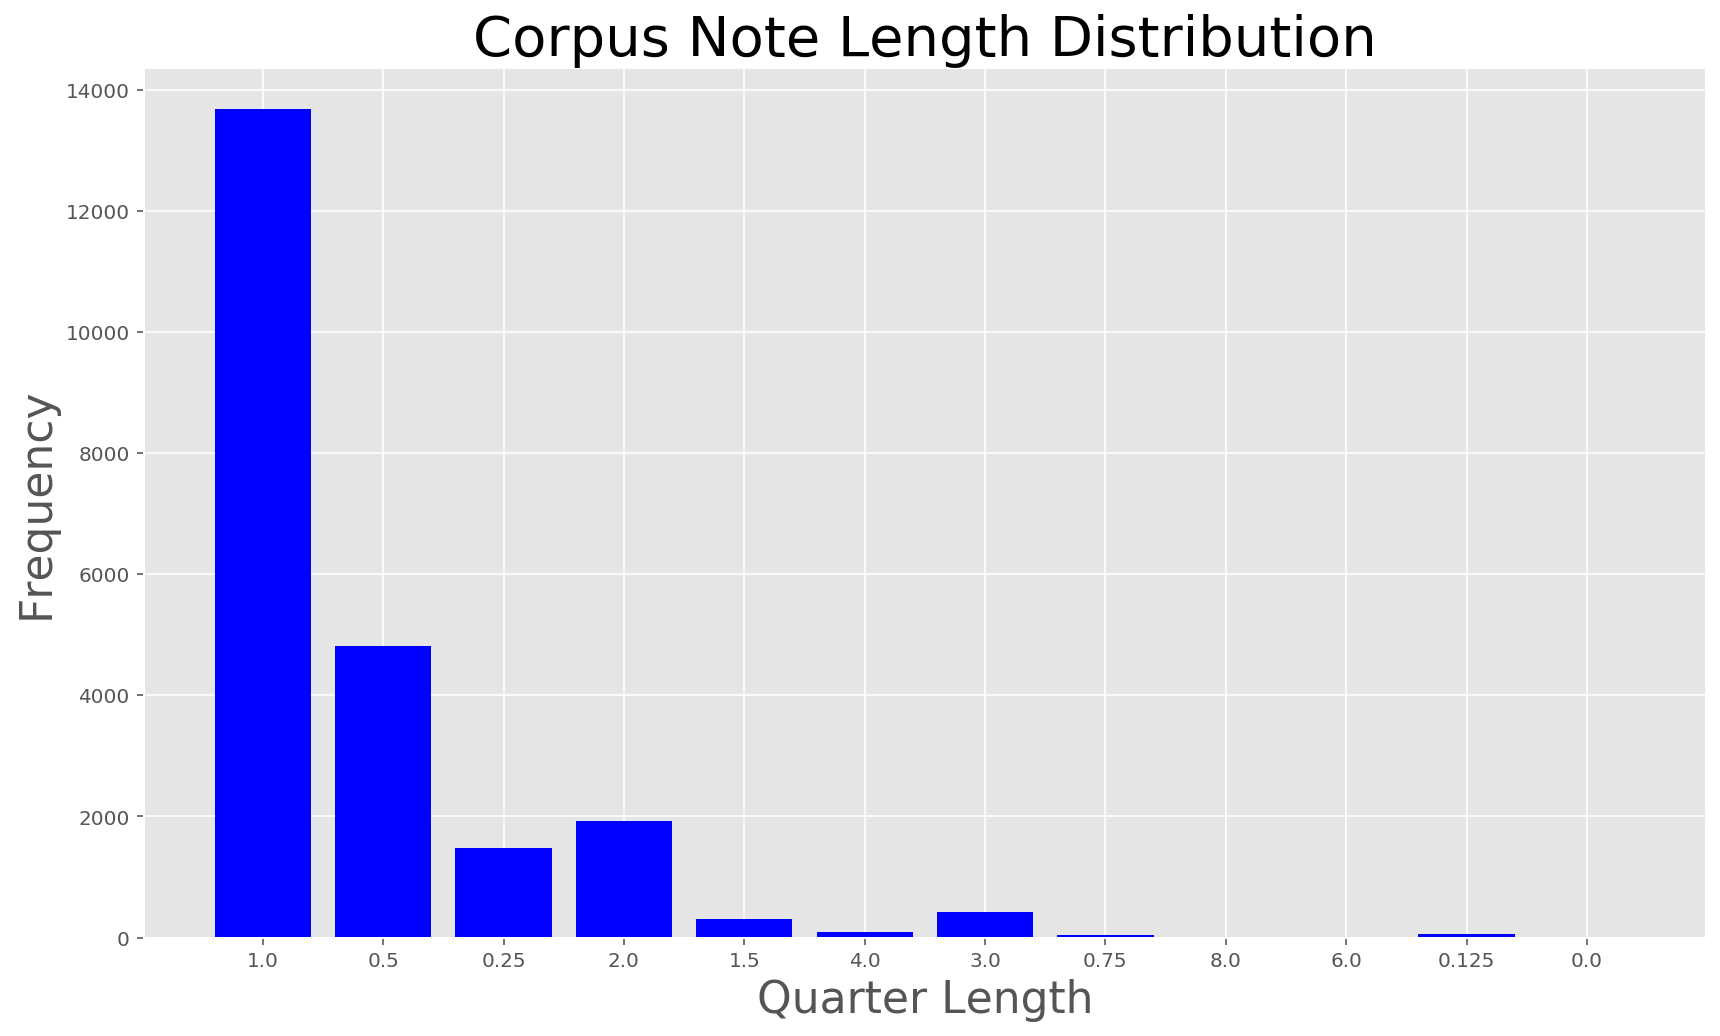

In [20]:
plt.figure(figsize=(14,8))
plt.bar(range(len(durations_dict)), list(durations_dict.values()), align='center', color='blue')
plt.xticks(range(len(durations_dict)), list(durations_dict.keys()))
plt.xlabel("Quarter Length", fontsize=22)
plt.ylabel("Frequency", fontsize=22)
plt.title("Corpus Note Length Distribution", fontsize=28)
plt.savefig('../figures/note_duration_distr.png', dpi=300)
plt.show()

In [5]:
#View pitch MIDI value frequencies of all chorale soprano parts
notes_dict = Counter(all_notes)
sorted(notes_dict)

[50,
 53,
 55,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 88]

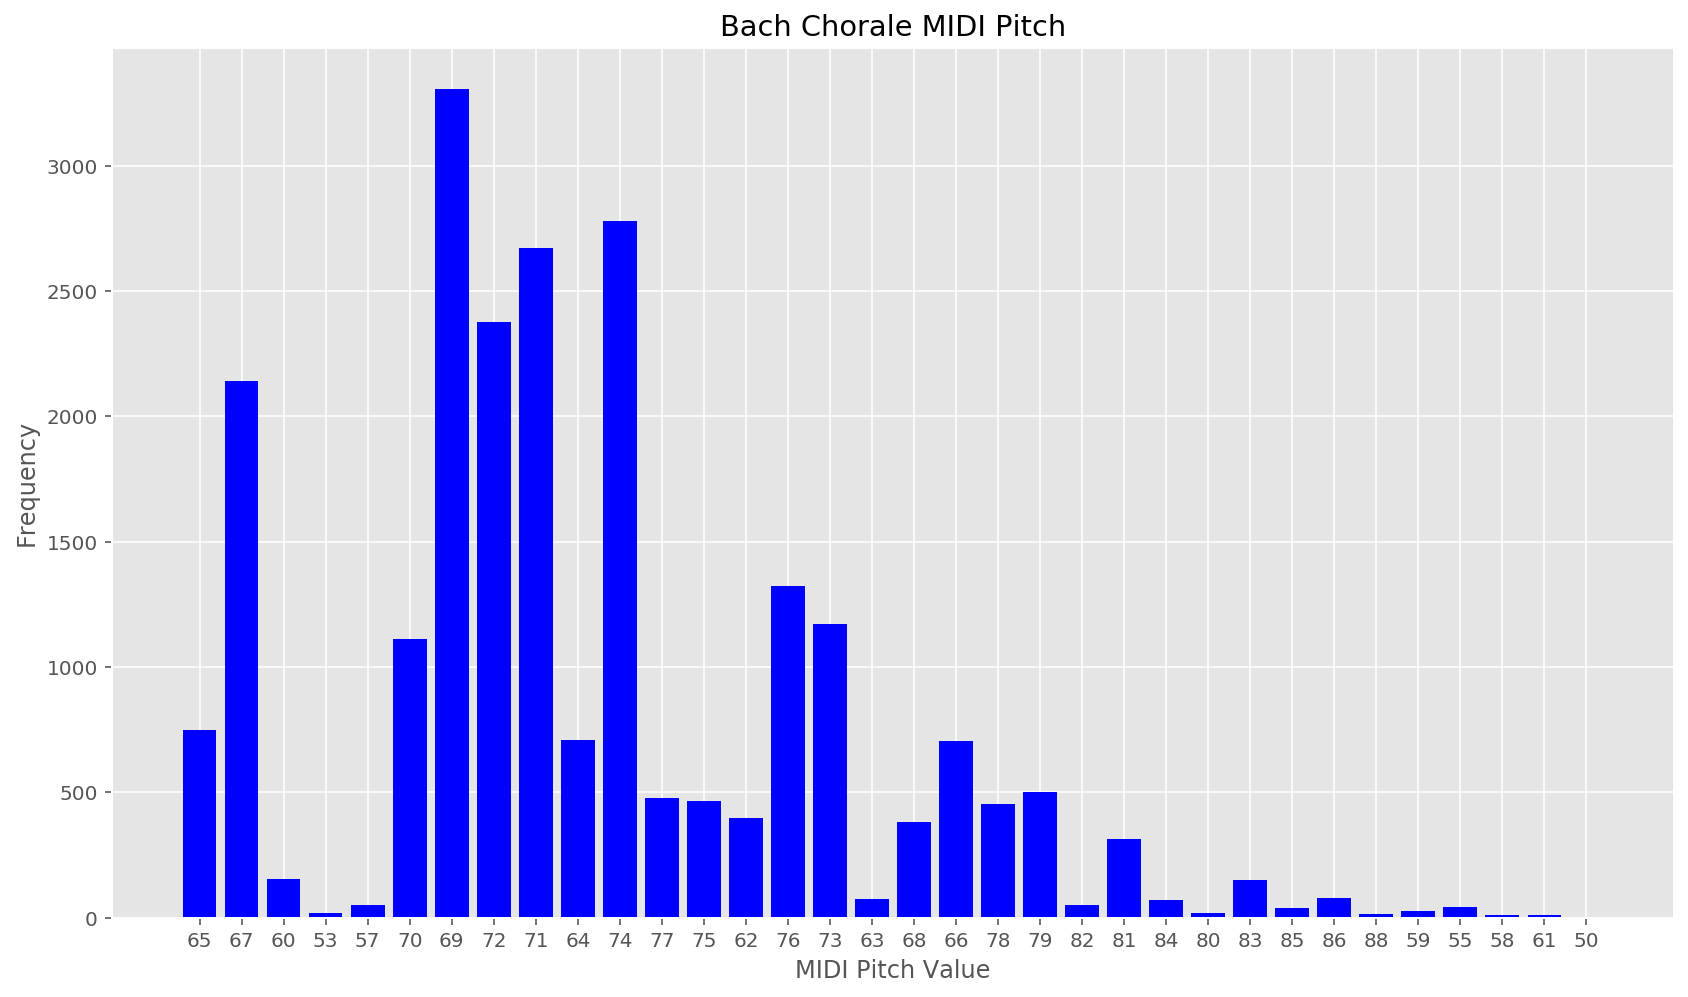

In [6]:
plt.figure(figsize=(14,8))
plt.bar(range(len(notes_dict)), list(notes_dict.values()), align='center', color='blue')
plt.xticks(range(len(notes_dict)), list(notes_dict.keys()))
plt.xlabel("MIDI Pitch Value")
plt.ylabel("Frequency")
plt.title("Bach Chorale MIDI Pitch")

plt.show()

In [7]:
chorales_notes_train[0]

[(65, 1.0),
 (67, 0.5),
 (60, 0.5),
 (65, 0.5),
 (53, 0.5),
 (57, 0.5),
 (53, 0.5),
 (57, 0.5),
 (60, 0.5),
 (65, 0.25),
 (70, 0.25),
 (69, 0.25),
 (67, 0.25),
 (65, 0.5),
 (67, 0.5),
 (69, 1.0),
 (69, 1.0),
 (65, 0.5),
 (67, 0.25),
 (69, 0.25),
 (70, 0.5),
 (72, 0.25),
 (70, 0.25),
 (69, 0.5),
 (67, 0.5),
 (67, 0.5),
 (72, 0.5),
 (72, 0.5),
 (71, 0.25),
 (69, 0.25),
 (71, 1.0),
 (72, 1.0),
 (65, 1.0),
 (65, 0.5),
 (70, 0.5),
 (69, 0.5),
 (67, 0.5),
 (65, 0.5),
 (60, 0.5),
 (65, 0.5),
 (60, 0.5),
 (60, 0.5),
 (57, 0.25),
 (53, 0.25),
 (60, 0.5),
 (60, 0.25),
 (60, 0.25),
 (57, 1.0),
 (65, 1.0),
 (67, 0.5),
 (60, 0.5),
 (65, 0.5),
 (53, 0.5),
 (57, 0.5),
 (53, 0.5),
 (57, 0.5),
 (60, 0.5),
 (65, 0.25),
 (70, 0.25),
 (69, 0.25),
 (67, 0.25),
 (65, 0.5),
 (67, 0.5),
 (69, 1.0),
 (69, 1.0),
 (65, 0.5),
 (67, 0.25),
 (69, 0.25),
 (70, 0.5),
 (72, 0.25),
 (70, 0.25),
 (69, 0.5),
 (67, 0.5),
 (67, 0.5),
 (72, 0.5),
 (72, 0.5),
 (71, 0.25),
 (69, 0.25),
 (71, 1.0),
 (72, 1.0),
 (65, 1.0),
 (65

In [8]:
print(f"Number of chorales analyzed: {len(chorales_notes_train)}")

Number of chorales analyzed: 433


In [9]:
#Visualize chords analyzed in corpus

chorales_chords_train[0]

['I',
 'V6',
 'V6',
 'I',
 'I',
 'vi',
 'vi',
 'I6',
 'I6',
 'IV',
 'IV',
 'IV7642',
 'ii7542',
 'IV6',
 'vii/o7532',
 'I',
 'I',
 'IV',
 'ii65',
 'IV7',
 'viio752',
 'V43',
 'viio6',
 'I6',
 'II65',
 'V',
 'V',
 'vi65',
 '#iv/ob7b64b3',
 'vi763',
 'II',
 'V',
 'I',
 'I',
 'IV',
 'ii65',
 'iii6',
 'iii65',
 'IV65',
 'V65',
 'I',
 'I',
 'i54',
 'I654',
 'I654',
 'V7',
 'V7',
 'V7',
 'I',
 'I',
 'V6',
 'V6',
 'I',
 'I',
 'vi',
 'vi',
 'I6',
 'I6',
 'IV',
 'IV',
 'IV7642',
 'ii7542',
 'IV6',
 'vii/o7532',
 'I',
 'I',
 'IV',
 'ii65',
 'IV7',
 'viio752',
 'V43',
 'viio6',
 'I6',
 'II65',
 'V',
 'V',
 'vi65',
 '#iv/ob7b64b3',
 'vi763',
 'II',
 'V',
 'I',
 'I',
 'IV',
 'ii65',
 'iii6',
 'iii65',
 'IV65',
 'V65',
 'I',
 'I',
 'i54',
 'I654',
 'I654',
 'V7',
 'V7',
 'V7',
 'I',
 'V6',
 'V6',
 'V6',
 'V6',
 'V6',
 'V6',
 'V6',
 'I',
 'i54',
 'i4',
 'V',
 'vi62',
 'V',
 'I',
 'I',
 'I742',
 'I6',
 'I',
 'V',
 'V7642',
 'iii7542',
 'V65',
 'V',
 'V7',
 'I',
 'I742',
 'I6',
 'I',
 'V',
 'I752',
 'I

In [10]:
#View chord counts over the entire corpus
chords_dict = Counter(all_chords)
chords_dict

Counter({'I': 3326,
         'V6': 825,
         'vi': 1027,
         'I6': 1151,
         'IV': 883,
         'IV7642': 2,
         'ii7542': 10,
         'IV6': 559,
         'vii/o7532': 11,
         'ii65': 275,
         'IV7': 164,
         'viio752': 23,
         'V43': 69,
         'viio6': 302,
         'II65': 171,
         'V': 2669,
         'vi65': 165,
         '#iv/ob7b64b3': 2,
         'vi763': 8,
         'II': 371,
         'iii6': 177,
         'iii65': 71,
         'IV65': 160,
         'V65': 355,
         'i54': 404,
         'I654': 37,
         'V7': 632,
         'i4': 52,
         'vi62': 6,
         'I742': 94,
         'V7642': 1,
         'iii7542': 1,
         'I752': 131,
         'ii': 593,
         'ii7': 291,
         'vii/o65': 49,
         'vi6432': 12,
         'ii42': 126,
         'vi543': 14,
         'vi6': 230,
         'IV43': 40,
         'iii': 392,
         'iii7': 150,
         'IV532': 71,
         'iv54': 191,
         'ii732': 23,
     

In [11]:
print("Number of distinct chords in corpus: ", len(chords_dict.keys()))

Number of distinct chords in corpus:  1119


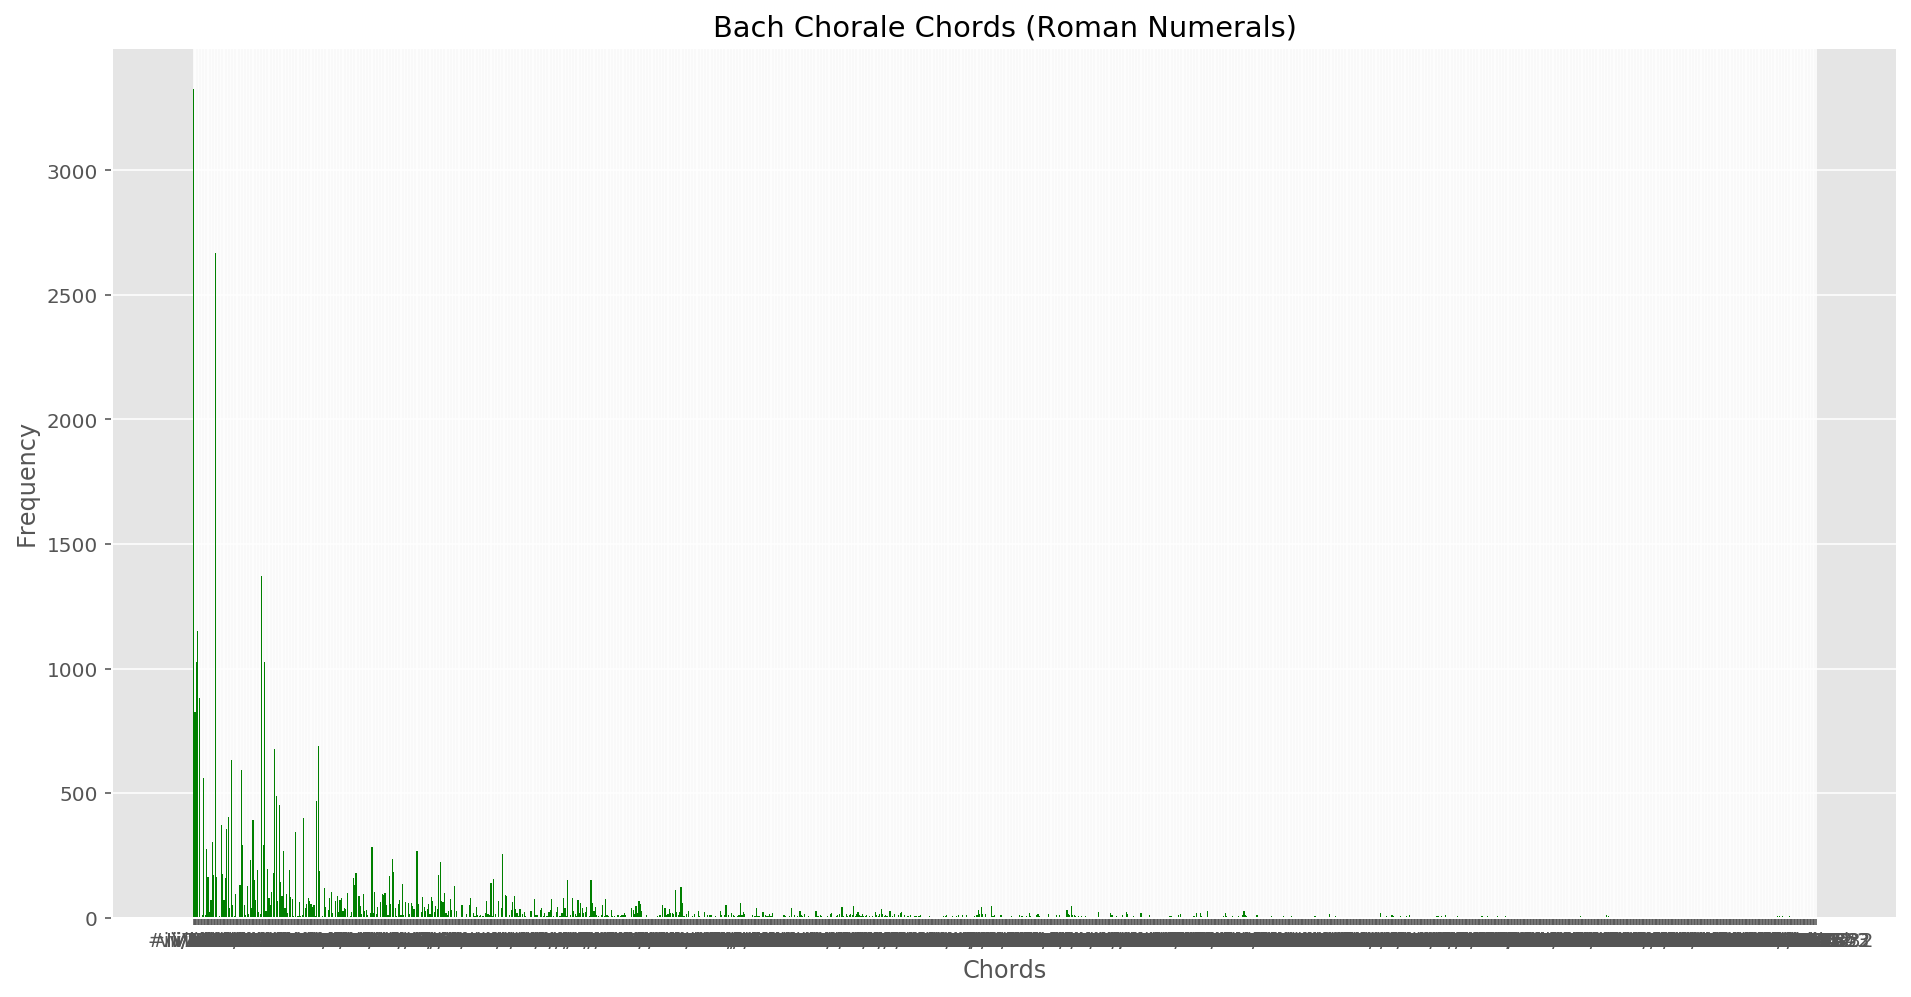

In [12]:
plt.figure(figsize=(16,8))
plt.bar(range(len(chords_dict)), list(chords_dict.values()), align='center', color='green')
plt.xticks(range(len(chords_dict)), list(chords_dict.keys()))
plt.xlabel("Chords")
plt.ylabel("Frequency")
plt.title("Bach Chorale Chords (Roman Numerals)")

plt.show()

In [13]:
with open('pickles/starting_duration_likelihood.pickle', 'rb') as f:
    starting_duration_likelihood = pickle.load(f)
    
with open('pickles/starting_pitch_likelihood.pickle', 'rb') as f:
    starting_pitch_likelihood = pickle.load(f)

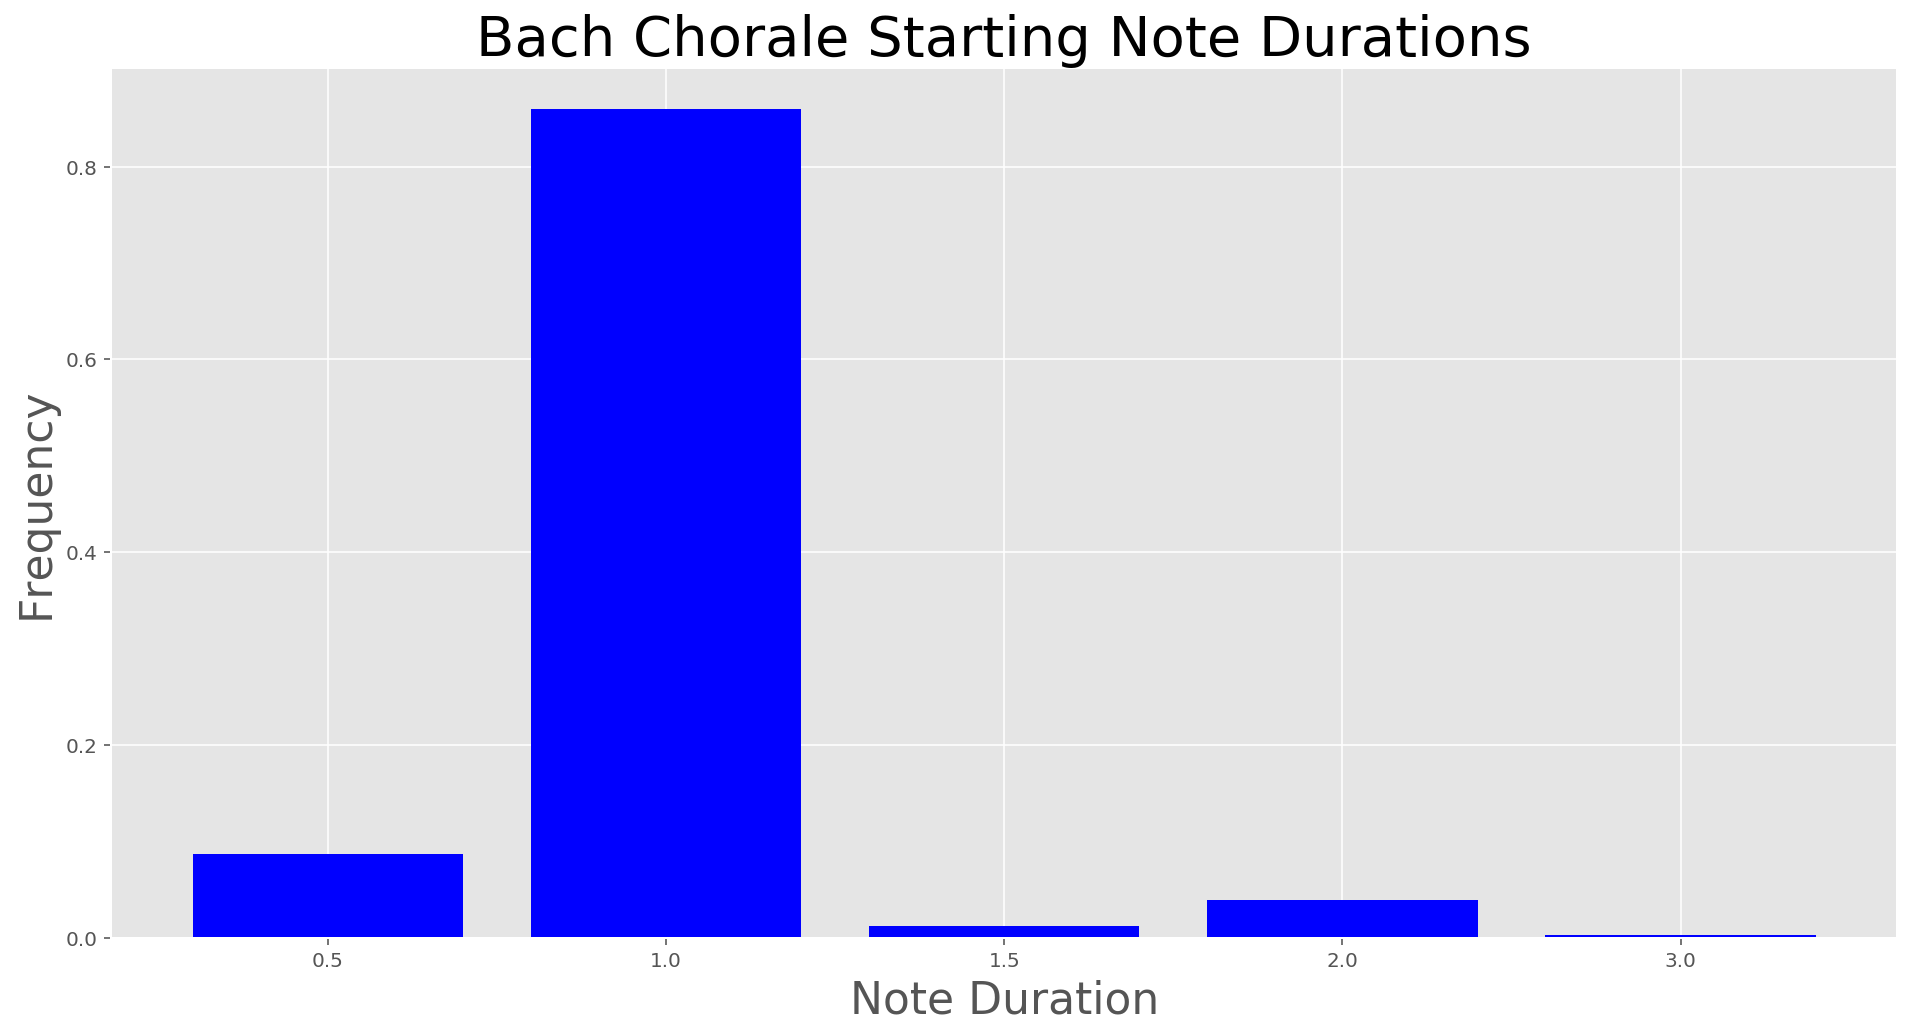

In [18]:
plt.figure(figsize=(16, 8))
plt.bar(range(len(starting_duration_likelihood)), list(starting_duration_likelihood.values()), color="blue")
plt.xticks(range(len(starting_duration_likelihood.keys())), list(starting_duration_likelihood.keys()))
plt.xlabel("Note Duration", fontsize=22)
plt.ylabel("Frequency", fontsize=22)
plt.title("Bach Chorale Starting Note Durations", fontsize=28)
plt.savefig('../figures/start_duration_distr.png', dpi=300)
plt.show()

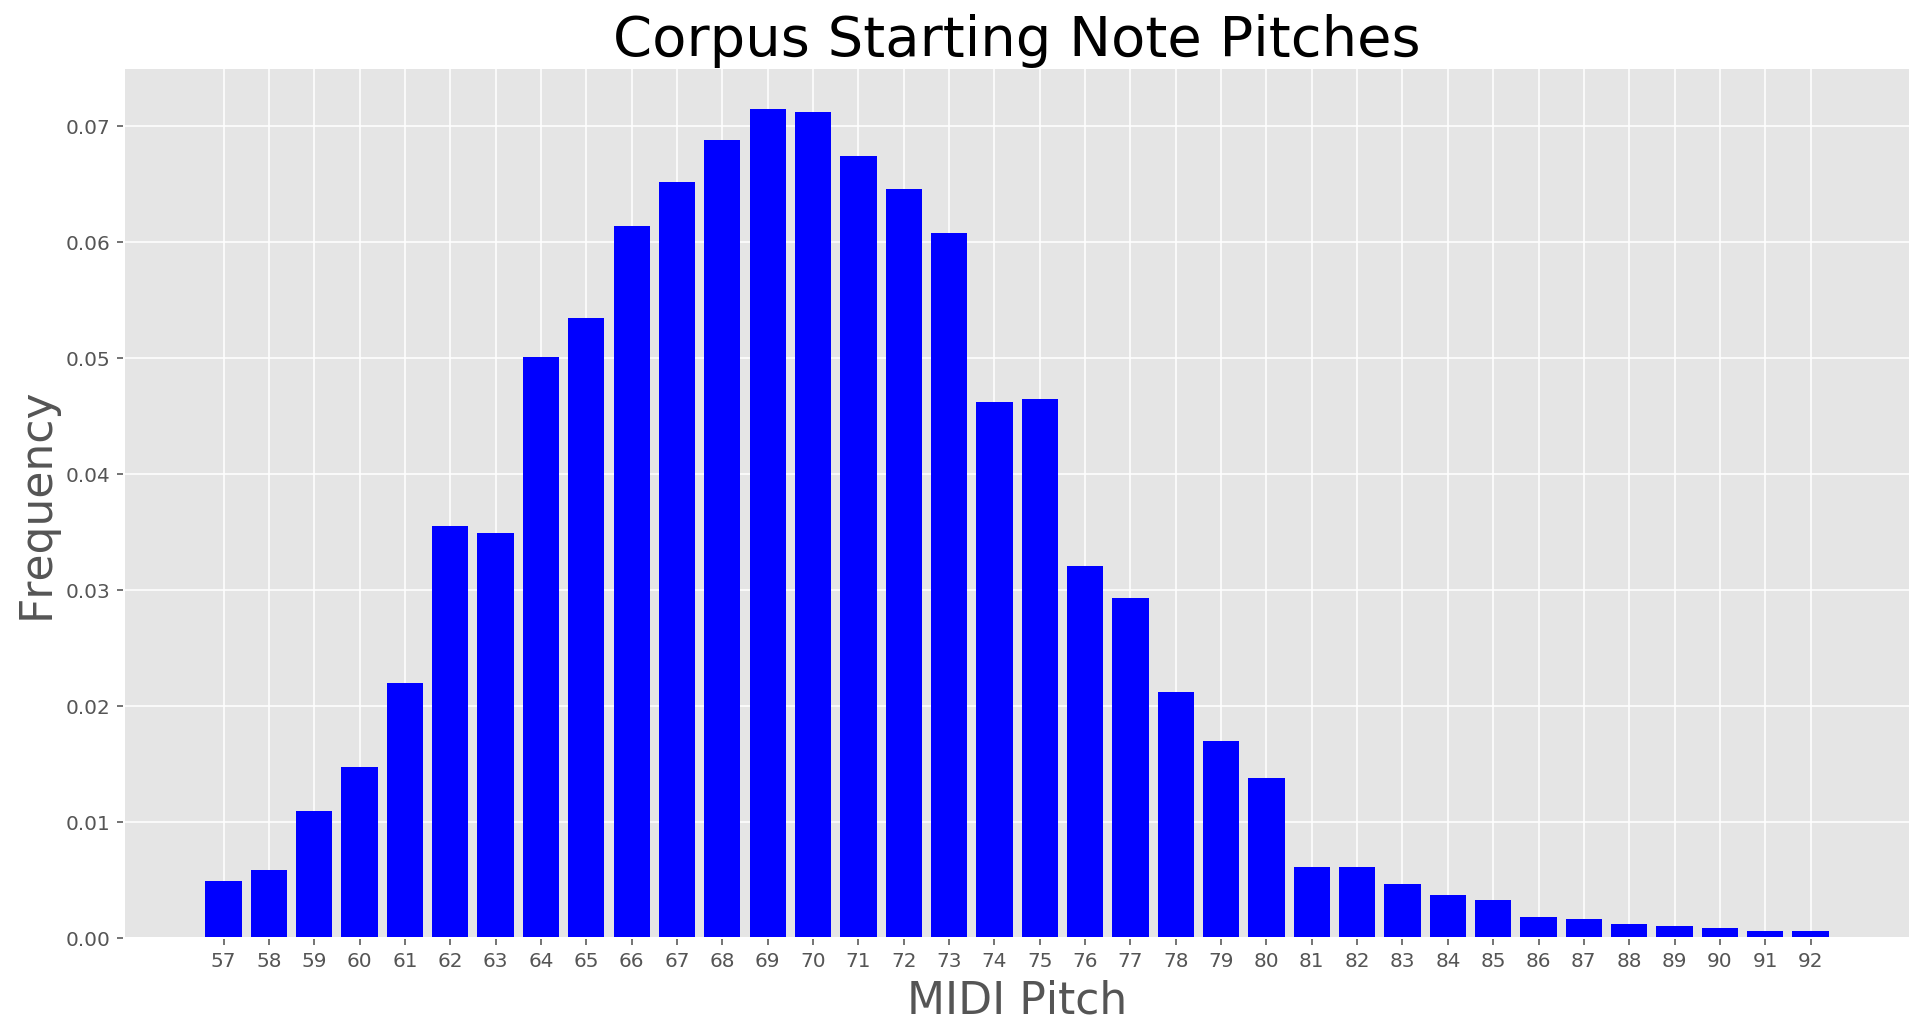

In [17]:
plt.figure(figsize=(16,8))
plt.bar(range(len(starting_pitch_likelihood)), list(starting_pitch_likelihood.values()), color="blue")
plt.xticks(range(len(starting_pitch_likelihood.keys())), list(starting_pitch_likelihood.keys()))
plt.xlabel("MIDI Pitch", fontsize=22)
plt.ylabel("Frequency", fontsize=22)
plt.title("Corpus Starting Note Pitches", fontsize=28)
plt.savefig('../figures/start_pitch_distr.png', dpi=300)
plt.show()